<h1 style="font-size: 42px; text-align: center;">HW5: Monte Carlo Tree Search and Naive Search</h1>

> **Full Name:** `Payam Taebi`  
> **Student ID:** `400104867`  

<p align="center">
    <a href="https://colab.research.google.com/github/DeepRLCourse/Homework-5-Questions/blob/main/RL_HW5_MCTS.ipynb">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab">
    </a>
    <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/DeepRLCourse/Homework-5-Questions/main/RL_HW5_MCTS.ipynb">
        <img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Kaggle">
    </a>
</p>

---

## 📌 Overview

Welcome to **HW5**, where you will explore and implement search algorithms in reinforcement learning!  
In this assignment, you will:

✅ Implement **Monte Carlo Tree Search (MCTS)** and a **Naive Search Algorithm**.  
✅ Develop an agent that utilizes these techniques for decision-making.  
✅ Test and evaluate the performance of your agent.  

### 📂 Notebook Structure:
1️⃣ **Environment Definition**  
2️⃣ **Search Algorithms: Naive Search & MCTS**  
3️⃣ **Agent Implementation**  
4️⃣ **Training & Testing Loop**  

💡 *Each section includes explanations, docstrings, and `TODO` placeholders for missing implementations. Fill in the gaps and complete the assignment!*  

🚀 *Let's get started!*  


# Detailed Explanation of the Overall Algorithm

This notebook implements a MuZero-like approach to reinforcement learning, as described in the paper  
[“Mastering Atari, Go, Chess and Shogi by Planning with a Learned Model” (Schrittwieser et al., 2019)](https://arxiv.org/abs/1911.08265).  
Below is an overview of the key components and how they work together:

---

## 1. Representation, Dynamics, and Prediction Networks

MuZero (and algorithms inspired by it) relies on three core neural networks:

1. **Representation Network (`RepresentationNet`)**  
   - **Goal**: Convert raw observations (e.g., game frames, board states) into a latent (hidden) state.  
   - **Why It Matters**: By encoding high-dimensional inputs (like pixel images) into a more compact form, downstream modules can operate efficiently on this latent space rather than the raw data.

2. **Dynamics Network (`DynamicsNet`)**  
   - **Goal**: Given the current hidden state and an action, predict the **next hidden state** and an **immediate reward estimate**.  
   - **Why It Matters**: This is the “model” portion of MuZero. It simulates how the hidden state changes when an action is taken, letting the algorithm plan forward without needing a hand-crafted or perfect simulator.

3. **Prediction Network (`PredictionNet`)**  
   - **Goal**: From a hidden state, predict:
     1. **A policy distribution** (probabilities of selecting each possible action)
     2. **A value estimate** (scalar measure of how good or bad the state is)  
   - **Why It Matters**: This guides the search and learning, telling us which actions are promising (policy) and how favorable the current position might be (value).

---

## 2. Monte Carlo Tree Search (MCTS) and Naive Depth Search

1. **Monte Carlo Tree Search (`MCTS` Class)**  
   - **Core Idea**: Repeatedly simulate many “what if?” scenarios (rollouts) to gather statistics on which actions lead to higher value.  
   - **Key Methods**:  
     - `run(...)`: Manages the entire search process from the root hidden state.  
     - `_expand_node(...)`: Expands a leaf node by calling the dynamics and prediction networks.  
     - `_backpropagate(...)`: Propagates the newly obtained value estimates back up the search path.  
     - `_calc_ucb(...)`: Calculates an Upper Confidence Bound (UCB) score to balance exploration (trying new actions) and exploitation (using known good actions).  
     - `_compute_pi()`: Aggregates the visit counts of each child action at the root to form a final policy distribution.  

2. **Naive Depth Search (`naive_depth_search(...)`)**  
   - **Core Idea**: Look ahead a fixed depth in a brute-force manner, expanding all action sequences up to that depth.  
   - **Why It Matters**: Though less sophisticated than MCTS, it offers a simpler example of planning. It enumerates action branches, accumulates rewards and discounted values, and then picks the best sequence.

---

## 3. Buffer Replay

- **Purpose**: Store entire trajectories (episodes) of experience, then allow sampling of smaller segments (sub-trajectories) for training.  
- **How**:  
  1. **`add_trajectories(...)`**: Inserts full episodes into the buffer.  
  2. **`sample_sub_trajectory(...)`**: Retrieves a sub-trajectory of length `k` (for an n-step return) from the stored episodes.  
  3. **`sample_batch(...)`**: Returns a batch of sub-trajectories for training the neural networks.  

---

## 4. Agent

- **Role**: Central coordinator that uses the networks (Representation, Dynamics, Prediction) and search algorithms (MCTS or naive) to choose actions.  
- **Key Functions**:
  1. **`inference(...)`**: Given an observation, the agent converts it to a hidden state, then either:
     - Runs MCTS to derive a policy (if `search_type="mcts"`)
     - Performs a naive depth search (if `search_type="naive"`)
     - Or uses the direct policy from the `PredictionNet` (if no search is enabled)  
    The chosen action, along with the policy distribution and value estimate, is returned.
  2. **`initial_step(...)`**: Processes the initial raw observation into a hidden state and then obtains policy/value estimates.  
  3. **`rollout_step(...)`**: Given a hidden state plus actions, calls the `DynamicsNet` to get the next hidden state and reward, and the `PredictionNet` to predict policy/value at that new state.

---

## 5. Overall Training Procedure

1. **Collect Trajectories**:  
   - The agent interacts with the environment, using either MCTS or naive search to pick actions.  
   - The environment returns observations/rewards that form trajectories (episodes).

2. **Store in Replay**:  
   - These full trajectories are added to the `BufferReplay`.

3. **Sample Mini-Batches**:  
   - The training script samples sub-trajectories from the buffer (via `sample_sub_trajectory(...)` or `sample_batch(...)`).

4. **Unroll the Model**:  
   - For each sampled sub-trajectory, the code unrolls the networks (`RepresentationNet`, `DynamicsNet`, `PredictionNet`) for multiple steps (up to `k`) to compare the model’s predictions to the actual transitions.

5. **Compute Loss & Update**:  
   - The total loss typically includes terms for:
     - **Value error** (predicted vs. actual return)
     - **Policy error** (predicted policy vs. search-derived/improved policy)
     - **Reward error** (predicted vs. actual immediate reward)  
   - Backpropagation updates the parameters of all three networks end-to-end.

6. **Repeat**:  
   - Continue this cycle of data collection and network updates until convergence.

## Library Imports

In [1]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import math

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dtype = torch.float

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
##############################################
# Environment Runner
##############################################
class EnvironmentRunner:
    """
    Manages interactions with an OpenAI Gym environment:
    - Resets the environment
    - Steps through it given an agent's actions
    - Logs returns and gathers trajectory data
    """

    def __init__(self, gym_env):
        self.gym_env = gym_env
        self.num_actions = self.gym_env.action_space.n

        self.observation = self.gym_env.reset()
        self.episodes_count = 0


    def run(self, agent, show_render=False):
            """
            Runs one full episode:
            1) Resets environment
            2) Steps until done
            3) Logs returns
            4) Returns the collected trajectory
            """
            obs_list = []
            actions_list = []
            rewards_list = []
            done_list = []
            policy_list = []
            values_list = []

            # initial reset
            self.observation = self.gym_env.reset()
            obs_list.append(torch.tensor(self.observation))

            finished = False
            while not finished:
                # Let agent infer the next action
                chosen_action, distribution, val_est = agent.inference(
                    torch.tensor(self.observation, dtype=dtype, device=device)
                )

                next_obs, reward, finished, info = self.gym_env.step(chosen_action)

                # Store
                obs_list.append(torch.tensor(next_obs))
                actions_list.append(chosen_action)
                policy_list.append(torch.tensor(distribution))
                values_list.append(val_est)
                rewards_list.append(torch.tensor(reward))
                done_list.append(finished)

                # Optional render
                if show_render:
                    self.gym_env.render()
                    time.sleep(0.024)

                self.observation = next_obs

            self.episodes_count += 1
            return self.build_trajectory(obs_list, actions_list, rewards_list, done_list, policy_list, values_list)

    @staticmethod
    def build_trajectory(obs, acts, rews, finished_flags, pols, vals):
        return {
            "obs": obs,
            "actions": acts,
            "rewards": rews,
            "dones": finished_flags,
            "pis": pols,
            "vs": vals,
            "length": len(obs)
        }
        
class LoggingEnvRunner(EnvironmentRunner):
    """
    Extends EnvironmentRunner to log episode returns.
    """
    def __init__(self, env):
        super().__init__(env)
        self.episode_returns = []

    def run(self, agent):
        trajectory = super().run(agent)  # normal run
        # Summation of the episode's rewards:
        ep_return = float(np.sum(trajectory["rewards"]))
        self.episode_returns.append(ep_return)
        return trajectory

In [4]:
##############################################
# A simple Gym Wrapper
##############################################
class GymWrapper(gym.Wrapper):
    """
    A wrapper that folds multiple historical observations
    into a single stacked observation.
    """

    def __init__(self, env, history_len):
        super().__init__(env)
        self.history_len = history_len
        self.obs_dim = env.observation_space.shape[0]
        self.num_actions = env.action_space.n

    def reset(self):
        self.episode_return = 0
        self.observations_rollout = []

        obs = self.env.reset()
        self.observations_rollout.append(obs)

        return self.aggregate()

    def aggregate(self):
        """
        Stacks the last N observations (with possible zero-padding).
        Returns them as a flattened array of shape (1, -1).
        """
        stacked = np.zeros((self.history_len, self.obs_dim))

        current_length = len(self.observations_rollout)
        if current_length == self.history_len:
            stacked = np.array(self.observations_rollout)
        else:
            stacked[self.history_len - current_length :] = np.array(
                self.observations_rollout
            )

        return stacked.flatten().reshape(1, -1)

    def step(self, action):
        next_obs, reward, done, info = self.env.step(action)
        self.update_history(next_obs)
        aggregated_obs = self.aggregate()

        self.episode_return += reward
        if done:
            info["return"] = self.episode_return

        return aggregated_obs, reward, done, info

    def update_history(self, new_obs):
        if len(self.observations_rollout) == self.history_len:
            # drop oldest
            self.observations_rollout = self.observations_rollout[1:]
        self.observations_rollout.append(new_obs)

# `BufferReplay` Class

This class manages a replay buffer for reinforcement learning, specifically storing entire trajectories (episodes). It supports two main operations:

1. **Storing Trajectories**:  
   - `add_trajectories(new_trajectories)`: Appends new trajectories to the buffer. If the capacity is exceeded, it overwrites old trajectories in a circular manner.

2. **Sampling Sub-Trajectories**:  
   - `sample_sub_trajectory(k, n, discount)`: Randomly selects a single trajectory from the buffer, chooses a random start index within that trajectory, and extracts a sub-trajectory of length `k` for training. It also computes an `n`-step return for each step in the sub-trajectory, taking into account the discount factor.  
   - `sample_batch(batch_size, k, n, discount)`: Repeats the above sub-trajectory sampling multiple times to form a training batch.

## Data Structure Returned by `sample_sub_trajectory`

`sample_sub_trajectory` returns a dictionary with the following keys:

- **"obs"**: The observation at the starting point of the sub-trajectory.  
  - Type/Shape: Typically a tensor (or array) representing the state.  
- **"pi"**: A list of policy distributions (one per timestep in the sub-trajectory).  
  - Type/Shape: Each entry is usually a tensor of shape `(num_actions,)`, giving the probability distribution over actions.  
- **"v"**: (If included in your design) a list of value estimates for each step in the sub-trajectory.  
  - Type/Shape: Each entry could be a tensor of shape `(1,)` or just a single scalar representing the value.  
- **"actions"**: A list of integers (or tensors) indicating which action was taken at each step.  
  - Type/Shape: Each entry typically an integer in the range `[0, num_actions-1]`.  
- **"rewards"**: A list of rewards obtained for each step in the sub-trajectory.  
  - Type/Shape: Each entry is typically a scalar tensor (or float).  
- **"return"**: A list of n-step returns corresponding to each timestep in the sub-trajectory.  
  - Type/Shape: Each entry is usually a scalar tensor (or float) representing the discounted sum of rewards plus a discounted bootstrap value.

Overall, this dictionary encapsulates all the necessary data (observation, actions, rewards, policy, value, returns) for training, allowing algorithms to perform n-step updates or other forms of training that depend on short sequences of experience.


In [5]:
##############################################
# Buffer Replay (Experience)
##############################################
class BufferReplay:
    """
    Stores entire episodes (trajectories), then allows sampling
    sub-portions for training (k-step unroll & n-step return).
    """

    def __init__(self, capacity, num_actions):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.num_actions = num_actions

    def add_trajectories(self, new_trajectories):
        """
        Inserts new trajectories (episodes) into the memory buffer.
        
        Iterates over each trajectory in `new_trajectories` and:
        1. If the buffer is not yet at capacity, appends a placeholder.
        2. Overwrites the oldest trajectory in a circular manner when full.
        3. Updates the internal position pointer accordingly.
        
        Parameters:
        -----------
        new_trajectories : list
            A list of trajectory dictionaries.
        """
        for traj in new_trajectories:
            if len(self.memory) < self.capacity:
                self.memory.append(None)
            self.memory[self.position] = traj
            self.position = (self.position + 1) % self.capacity


    def sample_sub_trajectory(self, k, n, discount):
        """
        Randomly picks a single stored trajectory and a start index,
        returning k-step unroll data plus n-step returns.
        """
        
        data = {
            "obs": None,
            "pi": [],
            "v": [],
            "actions": [],
            "rewards": [],
            "return": [],
        }
    
        # Choose a random trajectory
        mem_idx = np.random.choice(len(self.memory), 1)[0]
        chosen_length = self.memory[mem_idx]["length"]
        last_idx = chosen_length - 1
    
        # Random start
        start = np.random.choice(chosen_length, 1)[0]
    
        # We'll record the initial observation
        data["obs"] = self.memory[mem_idx]["obs"][start]
    
        # Collect data for each unroll step
        for step in range(start, start + k + 1):
            lookahead = step + n
    
            # If looking beyond trajectory end, v_n = 0
            if lookahead >= last_idx:
                future_value = torch.tensor([0.0], device=device, dtype=dtype)
            else:
                # Wrap the value in a tensor if it's not already one.
                future_value = torch.tensor(
                    self.memory[mem_idx]["vs"][lookahead],
                    device=device,
                    dtype=dtype
                ) * (discount ** n)
    
            # Sum of discounted rewards up to n or end
            total_val = future_value.clone()
            max_reward_idx = min(last_idx, lookahead)
            enumer_rewards = list(enumerate(self.memory[mem_idx]["rewards"][step:max_reward_idx]))
            for i, single_r in enumer_rewards:
                # Ensure the reward is a tensor.
                total_val += torch.tensor(single_r, device=device, dtype=dtype) * (discount ** i)
    
            data["return"].append(total_val)
    
            # Not storing reward for the very initial step in the unroll
            if step != start:
                if 0 < step <= last_idx:
                    data["rewards"].append(self.memory[mem_idx]["rewards"][step - 1])
                else:
                    data["rewards"].append(torch.tensor([0.0], device=device, dtype=dtype))
    
            # Pi distribution
            if 0 <= step < last_idx:
                data["pi"].append(self.memory[mem_idx]["pis"][step])
            else:
                uniform_probs = np.ones(self.num_actions) / self.num_actions
                data["pi"].append(torch.tensor(uniform_probs, dtype=dtype))
    
        # Build the real set of actions from the actual trajectory
        max_valid_step = min(last_idx - 1, start + k - 1)
        num_steps_valid = max_valid_step - start
        data["actions"] = self.memory[mem_idx]["actions"][start : start + num_steps_valid + 1]
    
        # Fill with random actions if we unroll beyond the stored trajectory
        fill_count = k - num_steps_valid + 1
        for _ in range(fill_count):
            rand_act = np.random.choice(self.num_actions, 1)[0]
            data["actions"].append(rand_act)
    
        return data


    def sample_batch(self, batch_size, k, n, discount=0.99):
        """
        Returns a batch (list) of sub trajectories. Each item
        in the batch has the keys: obs, pi, v, actions, rewards, return

        Parameters:
        -----------
        batch_size : int
            Number of sub-trajectories to sample.
        k : int
            Number of unroll steps in each sub-trajectory.
        n : int
            Horizon for n-step return.
        discount : float
            Discount factor.

        Returns:
        --------
        list
            A list of dictionaries, each containing sub-trajectory data
            (with the same keys as described in `sample_sub_trajectory`).
        """

        batch_data = []
        for _ in range(batch_size):
            sample = self.sample_sub_trajectory(k, n, discount)
            batch_data.append(sample)
        return batch_data

    def __len__(self):
        """
        Returns the current number of stored trajectories in memory.
        """
        return len(self.memory)


# Representation, Dynamics, and Prediction Models

These three neural network classes (`RepresentationNet`, `DynamicsNet`, `PredictionNet`) work together to model different aspects of an environment in a reinforcement learning (RL) setting, often inspired by algorithms like MuZero or similar approaches.

1. **`RepresentationNet`**  
   - **Goal**: Transform a raw observation (from the environment) into a **hidden state** vector.  
   - **Role in RL**: This hidden state often serves as a compact, learned representation of the environment’s information and is used by subsequent models (such as `DynamicsNet` and `PredictionNet`) to make predictions about future states, rewards, policies, and values.

2. **`DynamicsNet`**  
   - **Goal**: Predict the **next hidden state** and **immediate reward** from the **current hidden state** and an encoded action.  
   - **Role in RL**: This allows a learning algorithm to “imagine” how the environment transitions forward without directly querying the real environment, enabling planning and lookahead.

3. **`PredictionNet`**  
   - **Goal**: Given a hidden state, output a **policy** (probability distribution over possible actions) and a **value estimate** (scalar).  
   - **Role in RL**:  
     - The **policy** guides action selection, telling us which actions might be best at each timestep.  
     - The **value estimate** helps evaluate how good or bad a particular state is, assisting with learning.

## Form of the Desired Outputs
- **`RepresentationNet`**:  
  Outputs a **hidden state** tensor of shape `(batch_size, hidden_dim)`.
- **`DynamicsNet`**:  
  Outputs two tensors:  
  1. **Next hidden state** of shape `(batch_size, hidden_dim)`  
  2. **Reward estimate** of shape `(batch_size,)`
- **`PredictionNet`**:  
  Outputs two tensors:  
  1. **Policy** of shape `(batch_size, num_actions)`, representing a probability distribution over actions.  
  2. **Value** of shape `(batch_size,)`, representing a scalar estimate of the state value.


In [6]:
class RepresentationNet(nn.Module):
    """
    Maps an environment observation into a hidden state.

    This network transforms a raw input observation into a latent representation,
    which is used by other components of the algorithm.
    
    Output:
    - A hidden state tensor of shape (batch_size, hidden_dim).
    """
    def __init__(self, input_dim, hidden_dim):
        """
        Initializes layers to convert an observation of size `input_dim`
        into a `hidden_dim`-dimensional hidden state.
        
        Args:
            input_dim (int): Dimension of the input observation.
            hidden_dim (int): Dimension of the output hidden state.
        """
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, hidden_dim)
        )
    
    def forward(self, x):
        """
        Forward pass that maps the input observation `x` to a hidden state.
        
        Args:
            x (Tensor): Input tensor of shape (batch_size, input_dim).
            
        Returns:
            Tensor: Hidden state of shape (batch_size, hidden_dim).
        """
        return self.network(x)


In [7]:
class DynamicsNet(nn.Module):
    """
    Predicts the next hidden state and immediate reward
    from the current hidden state and action encoding.

    In Detail:
    ----------
    Given a current hidden state and an action (encoded as a scalar or one-hot),
    this network outputs:
    - Next hidden state (shape: (batch_size, hidden_dim))
    - A scalar reward estimate (shape: (batch_size,))
    """
    def __init__(self, hidden_dim, num_actions):
        """
        Initializes layers that combine `hidden_dim` features and
        an encoded action to produce the next hidden state and reward.

        Args:
            hidden_dim (int): The dimension of the hidden state.
            num_actions (int): The number of actions available (used for one-hot encoding).
        """
        super().__init__()
        # The input dimension is hidden_dim + 1, where the extra 1 represents the action encoding.
        self.num_hidden = hidden_dim
        self.num_actions = num_actions

        self.network = nn.Sequential(
            nn.Linear(hidden_dim + 1, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, hidden_dim + 1)  # Output: concatenated next hidden state and reward.
        )

    def forward(self, x):
        """
        Forward pass that takes a batch consisting of the current hidden state
        concatenated with the encoded action, and returns:
        - The next hidden state (first hidden_dim outputs)
        - The reward estimate (last output)

        Args:
            x (Tensor): Input tensor of shape (batch_size, hidden_dim + 1).

        Returns:
            Tuple[Tensor, Tensor]: A tuple containing:
                - Next hidden state (shape: (batch_size, hidden_dim))
                - Reward estimate (shape: (batch_size,))
        """
        out = self.network(x)
        next_hidden = out[:, :self.num_hidden]
        reward = out[:, -1]
        return next_hidden, reward


In [8]:
class PredictionNet(nn.Module):
    """
    Given a hidden state, outputs:
      - A policy distribution (size = num_actions)
      - A scalar value estimate (size = 1 per batch item)

    In Detail:
    ----------
    The model reads the hidden state (shape: (batch_size, hidden_dim)) and produces:
    - `policy`: A probability distribution over actions (shape: (batch_size, num_actions)).
    - `value`: A scalar estimate for each hidden state (shape: (batch_size,)).
    """
    def __init__(self, hidden_dim, num_actions):
        """
        Initializes layers to map a hidden state into policy logits
        (of length `num_actions`) and a scalar value estimate.
        
        Args:
            hidden_dim (int): The dimension of the hidden state.
            num_actions (int): The number of actions available.
        """
        super().__init__()
        self.num_actions = num_actions
        self.num_hidden = hidden_dim
        
        self.network = nn.Sequential(
            nn.Linear(hidden_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, num_actions + 1)  # First num_actions are logits for policy, last one is the value.
        )

    def forward(self, hidden_x):
        """
        Forward pass that takes a batch of hidden states `hidden_x`
        and produces the policy distribution and value estimate.
        
        Args:
            hidden_x (Tensor): Input hidden state of shape (batch_size, hidden_dim).
        
        Returns:
            Tuple[Tensor, Tensor]: A tuple containing:
                - policy (Tensor): A probability distribution over actions (shape: (batch_size, num_actions)).
                - value (Tensor): A scalar value estimate for each hidden state (shape: (batch_size,)).
        """
        out = self.network(hidden_x)
        p = out[:, :self.num_actions]  # Extract policy logits.
        v = out[:, -1]                 # Extract value estimate.
        p = F.softmax(p, dim=1)         # Convert logits to a probability distribution.
        return p, v


# MCTS And Naive Depth-Based Search

In this section, we have several classes and functions that support Monte Carlo Tree Search (MCTS) and a naive depth-based search approach:

1. **`AdaptiveNormalizer`**  
   - Tracks the running minimum and maximum values of inputs (e.g., Q-values).  
   - Allows for on-the-fly normalization of these values, which can stabilize the search process.

2. **`TreeNode`**  
   - Represents a node in the MCTS search tree.  
   - Stores statistics such as visit counts, the sum of value estimates, child edges, and prior probabilities.  
   - The node can also store a hidden state representation and an estimated reward for transitioning from a parent node.

3. **`MCTS` Class**  
   - Controls the MCTS search process.  
   - Contains key methods like `run`, `_expand_node`, `_backpropagate`, `_calc_ucb`, and `_compute_pi` for performing MCTS simulations, updating node statistics, and calculating action visit distributions.  
   - Uses a dynamics model and prediction model to simulate the environment forward and estimate policies/values.

4. **`naive_depth_search` Function**  
   - Demonstrates a simpler (but inefficient) depth-based search.  
   - Expands all actions up to a certain depth, computes rewards and leaf values, then picks the action sequence with the highest total return.

## Form of the Desired Outputs

- **`AdaptiveNormalizer`**:  
  - Provides two primary methods: `update(val)` to update min/max stats and `normalize(val)` to scale values into a normalized range.

- **`TreeNode`**:  
  - Stores `edges` mapping each possible action to another `TreeNode`.  
  - Maintains `avg_value` (the mean of all values backpropagated through it), `visit_count`, and `total_value_sum`.  
  - It may store `state_rep` (the current hidden state representation) and `reward_est` (the immediate reward from the parent node to itself).

- **`MCTS`**:  
  1. **`run(sims_count, root_state)`**:  
     - Orchestrates the entire MCTS procedure for a given number of simulations (`sims_count`).  
     - Returns the **visit counts** over actions (used to derive a policy) and the **average value** of the root node.  
  2. **`_expand_node(parent_node, new_node, chosen_action)`**:  
     - Expands the leaf node by calling the environment (or model) with a chosen action, obtaining the next hidden state, policy, value, and reward.  
     - Creates children edges for all possible actions from the new state.  
     - Returns the new value estimate for further backpropagation.  
  3. **`_backpropagate(leaf_value)`**:  
     - Starts at the leaf node and moves backward through the search path, updating each node’s visit count and total value sum with the discounted reward.  
  4. **`_calc_ucb(parent, child)`**:  
     - Calculates the Upper Confidence Bound (UCB) score for a given child node.  
     - Uses the node’s prior probability, visit counts, and normalized value estimates to balance exploration and exploitation.  
     - Returns a scalar score that can be used to pick the best child action.  
  5. **`_compute_pi()`**:  
     - Aggregates the visit counts for each action at the root node, which can be used as an approximate policy distribution.

- **`naive_depth_search`**:  
  - Explores every possible action combination up to a specified depth (`search_depth`).  
  - Accumulates reward and discounted values, then selects the best action path found.

Below, the bodies of certain functions have been removed and replaced with detailed docstrings explaining the required logic, along with a `TODO: Your code` placeholder.


In [9]:
class AdaptiveNormalizer:
    """
    Simple min-max normalizer that tracks running min/max
    so we can scale Q-values in MCTS.

    Form of Operation:
    ------------------
    - Tracks the minimum and maximum values observed so far.
    - After each update, incoming values can be scaled to [0,1].
    """

    def __init__(self):
        self.max_val = float("-inf")
        self.min_val = float("inf")

    def update(self, val):
        """
        Updates the running minimum and maximum with the new value.

        Parameters:
        -----------
        val : torch.Tensor
            The new value for which we update min/max stats.
        """
        val_cpu = val.cpu()
        self.max_val = max(self.max_val, val_cpu)
        self.min_val = min(self.min_val, val_cpu)

    def normalize(self, val):
        """
        Scales the given value into the [0,1] range based on current min/max.

        Parameters:
        -----------
        val : torch.Tensor
            The value to be normalized.

        Returns:
        --------
        torch.Tensor
            The normalized value in [0,1] if max_val > min_val,
            otherwise returns the original value.
        """
        val_cpu = val.cpu()
        if self.max_val > self.min_val:
            return ((val_cpu - self.min_val) / (self.max_val - self.min_val)).to(device)
        return val_cpu


In [10]:
class TreeNode:
    """
    Node for MCTS: stores children edges, prior,
    aggregated value stats, and so on.

    Attributes:
    -----------
    prior_prob : float
        The prior probability (from a policy network) of choosing
        the action that leads to this node from its parent.
    state_rep : torch.Tensor or None
        The hidden state representation if available.
    reward_est : torch.Tensor or float
        The immediate reward predicted for the transition from the parent node.
    edges : dict
        A dictionary mapping each action to a child TreeNode.
    total_value_sum : float
        Sum of all backpropagated values.
    visit_count : int
        Number of times this node has been visited.
    """

    def __init__(self, prior_prob):
        self.prior_prob = prior_prob
        self.state_rep = None
        self.reward_est = None
        self.edges = {}  # action -> TreeNode

        self.total_value_sum = 0.0
        self.visit_count = 0

    def is_expanded(self):
        """
        Checks if the node has any child edges.

        Returns:
        --------
        bool
            True if there is at least one child edge, otherwise False.
        """
        return len(self.edges) > 0

    def avg_value(self):
        """
        Computes the average value estimate (total_value_sum / visit_count).

        Returns:
        --------
        float
            The mean value estimate. Returns 0.0 if visit_count is zero.
        """
        if self.visit_count == 0:
            return 0.0
        return self.total_value_sum / self.visit_count


In [11]:
##############################################
# Some utility function
##############################################


def minmax_normalize_state(s):
    """
    Simple bounding of the input tensor to [0,1] range per row.
    Not guaranteed to be safe for all tasks, but included for example.

    Parameters:
    -----------
    s : torch.Tensor
        The state tensor to normalize (shape: [batch_size, state_dim])

    Returns:
    --------
    torch.Tensor
        The normalized state tensor (element-wise scaled to [0,1]).
    """
    b_size = s.shape[0]
    s_min = torch.min(s, dim=1)[0].reshape(b_size, 1)
    s_max = torch.max(s, dim=1)[0].reshape(b_size, 1)
    return (s - s_min) / (s_max - s_min)

In [12]:
class MCTS:
    """
    Runs MCTS simulations to select actions.
    Has:
      - root exploration noise
      - expansions
      - backup of value
      - UCB calculation

    Methods of Interest:
    --------------------
    - run(sims_count, root_state): Orchestrates the entire MCTS procedure.
    - _expand_node(parent_node, new_node, chosen_action): Creates children edges for a leaf node.
    - _backpropagate(leaf_value): Updates nodes' stats from leaf to root.
    - _calc_ucb(parent, child): Calculates UCB score for a child node.
    - _compute_pi(): Gathers visit counts at the root node.
    """

    def __init__(self, num_actions, dynamics_model, prediction_model, controlling_agent, gamma=0.99):
        self.num_actions = num_actions
        # Initialize exploration constants (tuned per typical MuZero settings)
        self.c1 = 1.25
        self.c2 = 19652
        self.gamma = gamma

        self.root_dirichlet_alpha = 0.25
        self.root_exploration_fraction = 0.25

        self.dynamics_model = dynamics_model
        self.prediction_model = prediction_model
        self.agent = controlling_agent
        self.value_tracker = None  # This will be set at the start of each search

    def run(self, sims_count, root_state):
        """
        Orchestrates the entire MCTS process from a given root state.
        1. Creates a root node using the prediction model.
        2. Runs a number of MCTS simulations, where each simulation:
           - Traverses the tree using UCB-based action selection.
           - Expands a leaf node.
           - Backpropagates the value estimate up the search path.
        3. Computes and returns the visit counts (policy distribution) at the root and its average value.

        Returns:
            (np.array, float): Visit counts per action at the root and the average root value.
        """
        # Create the root using the prediction model
        init_policy, init_value = self.prediction_model(root_state)
        init_policy, init_value = init_policy.detach(), init_value.detach()
        self.root_node = self._initialize_root(root_state, init_policy)

        # Initialize the value normalizer (can help stabilize UCB calculation)
        self.value_tracker = AdaptiveNormalizer()

        # Run MCTS simulations
        for _ in range(sims_count):
            self.search_path = []
            self.search_path.append(self.root_node)
            self.action_path = []
            
            current_node = self.root_node
            # Traverse down the tree using UCB until a leaf is reached.
            while current_node.is_expanded():
                act_chosen, next_node = self._select_ucb_action(current_node)
                self.search_path.append(next_node)
                self.action_path.append(act_chosen)
                current_node = next_node

            # Expand the reached leaf:
            # The parent of the leaf is the last expanded node before the leaf.
            leaf_parent = self.search_path[-2]
            new_value = self._expand_node(leaf_parent, current_node, self.action_path[-1])
            # Backpropagate the value estimate along the search path.
            self._backpropagate(new_value)

        # Compute the policy (visit counts) at the root.
        pi = self._compute_pi()
        return pi, self.root_node.avg_value()

    def _expand_node(self, parent_node, new_node, chosen_action):
        """
        Expands a leaf node by querying the model via the controlling agent.
        1. Performs a rollout step from parent_node's state with chosen_action.
        2. Receives next hidden state, policy, value, and reward.
        3. Updates new_node with these estimates.
        4. Creates children edges for each action with their prior probabilities.
        5. Returns the new value estimate for backpropagation.
        """
        # Rollout step: agent handles the dynamics/prediction combination.
        next_s, new_pi, new_v, new_reward = self.agent.rollout_step(parent_node.state_rep, [chosen_action])
        next_s, new_pi, new_v, new_reward = (
            next_s.detach(),
            new_pi.detach(),
            new_v.detach(),
            new_reward.detach(),
        )

        # Update the new node with the new state and reward estimate.
        new_node.state_rep = next_s
        new_node.reward_est = new_reward

        # Create children edges for each action using the new policy prior.
        for a in range(self.num_actions):
            # Use .item() to convert from a tensor scalar to float.
            new_node.edges[a] = TreeNode(new_pi[0, a].item())
        return new_v

    def _backpropagate(self, leaf_value):
        """
        Moves up the search path, updating each node's total value sum and visit count.
        Also updates the normalizer with the combined node reward and discounted value.
        The leaf_value is updated iteratively:
            leaf_value = node.reward_est + gamma * leaf_value
        """
        # Iterate in reverse (from leaf to root)
        for node in reversed(self.search_path):
            # Accumulate value sum and count visits.
            val_to_add = leaf_value.item() if isinstance(leaf_value, torch.Tensor) else leaf_value
            node.total_value_sum += val_to_add
            node.visit_count += 1
            
            # Update the normalizer using the node's reward plus discounted average value.
            value_to_update = (
                node.reward_est + self.gamma * node.avg_value()
                if node.reward_est is not None
                else 0.0
            )
            self.value_tracker.update(torch.tensor([value_to_update], device=device, dtype=dtype))
            
            # Update leaf_value for the parent node.
            if node.reward_est is not None:
                leaf_value = node.reward_est + self.gamma * leaf_value

    def _select_ucb_action(self, node):
        """
        Selects the action with the highest UCB score among the children of `node`.
        Returns:
            (int, TreeNode): The chosen action index and its corresponding child node.
        """
        ucb_scores = [self._calc_ucb(node, node.edges[a]) for a in range(self.num_actions)]
        best_act = np.argmax(ucb_scores)
        return best_act, node.edges[best_act]

    def _calc_ucb(self, parent, child):
        """
        Calculates the UCB (PUCT) score for a child node.
        Combines an exploration term (dependent on parent's visits and child's prior)
        with a normalized value estimate (reward plus discounted average value).

        Returns:
            float: The computed UCB score.
        """
        pb_c = math.log((parent.visit_count + self.c2 + 1) / self.c2) + self.c1
        pb_c *= math.sqrt(parent.visit_count) / (child.visit_count + 1)
        prior_val = pb_c * child.prior_prob

        if child.visit_count > 0:
            # Normalize the value term using the current normalizer.
            val_term = child.reward_est + self.gamma * child.avg_value()
            # Convert to a float value.
            val_score = self.value_tracker.normalize(val_term).item()
        else:
            val_score = 0.0

        return prior_val + val_score

    def _compute_pi(self):
        """
        Aggregates the visit counts of each child of the root node to form a policy distribution.
        Returns:
            np.array: An array of visit counts (one per action).
        """
        visits = []
        for a in range(self.num_actions):
            visits.append(self.root_node.edges[a].visit_count)
        return np.array(visits)

    def _add_root_noise(self, root):
        """
        Adds Dirichlet noise to the root node's child prior probabilities to encourage exploration.
        """
        noise = np.random.dirichlet([self.root_dirichlet_alpha] * self.num_actions)
        frac = self.root_exploration_fraction
        for act_id, n_val in zip(range(self.num_actions), noise):
            root.edges[act_id].prior_prob = (
                root.edges[act_id].prior_prob * (1 - frac) + n_val * frac
            )
        return root

    def _initialize_root(self, root_tensor, p_init):
        """
        Initializes the root node with policy priors for each action and adds exploration noise.
        """
        p_init = p_init.detach().cpu().numpy()
        node = TreeNode(0)
        node.state_rep = root_tensor
        node.reward_est = 0

        for i in range(self.num_actions):
            node.edges[i] = TreeNode(p_init[0, i])
        node = self._add_root_noise(node)
        return node


In [13]:
def naive_depth_search(agent, hidden_s, act_count, gamma_val, search_depth=3):
    """
    Very naive search that fully expands all actions up to a given depth,
    tracks predicted reward + discounted value at the leaf, and picks the best
    root action based on these expansions.

    Parameters:
    -----------
    agent : object
        The agent that provides a `prediction_model` and `rollout_step` method.
    hidden_s : torch.Tensor
        The current hidden state representation (shape: (1, hidden_dim)).
    act_count : int
        The number of possible actions in the environment.
    gamma_val : float
        The discount factor applied to future rewards and values.
    search_depth : int
        The maximum depth up to which actions are enumerated.

    Returns:
    --------
    (int, torch.Tensor)
        - The best action to take at the root (index into the action space).
        - The estimated root value from `agent.prediction_model`.
    """
    # Possible actions as an array: [0, 1, ..., act_count-1]
    possible_actions = np.arange(act_count)
    
    # Get the root value prediction
    _, root_v = agent.pred_net(hidden_s)
    
    # Initialize rewards accumulator as a tensor on the proper device and type
    rewards = torch.tensor([0.0], device=device, dtype=dtype)
    
    state = hidden_s  # starting state
    # For each depth level, expand the tree
    for depth in range(search_depth):
        # Expand the current state: repeat it for each action branch.
        state = torch.repeat_interleave(state, act_count, dim=0)
        # Generate the list of actions for the current depth:
        # For depth=0, we have act_count branches; for depth>0, repeat the possible actions accordingly.
        actions = np.repeat([possible_actions], act_count ** depth, axis=0).flatten()
        
        # Rollout one step for every branch.
        # rollout_step returns (next_state, new_policy, value, reward)
        state, _, v, reward = agent.rollout_step(state, actions)
        state, v, reward = state.detach(), v.detach(), reward.detach()
        
        # Repeat the accumulated rewards to match the current branching factor.
        rewards = torch.repeat_interleave(rewards, act_count, dim=0)
        # Discount the immediate reward at the current depth and add it.
        adjusted_r = reward * (gamma_val ** depth)
        rewards = rewards + adjusted_r
    
    # Discount the final value prediction from the leaf nodes.
    final_vals = v * (gamma_val ** search_depth)
    # Total return for each branch: discounted final value plus accumulated rewards.
    total_vals = final_vals + rewards
    
    # Convert to numpy for branch selection.
    total_vals_np = total_vals.cpu().numpy()
    # Identify the branch with the highest total return.
    max_index = np.argmax(total_vals_np)
    # The first action in each branch is repeated every (act_count ** (search_depth - 1)) branches.
    indexes_per_action = act_count ** (search_depth - 1)
    best_action = int(max_index // indexes_per_action)
    
    return best_action, root_v


# `Agent` Class

The `Agent` class is a neural network module that coordinates between:
- A **representation network** (`rep_net`) to encode raw observations into a hidden state.
- A **dynamics network** (`dyn_net`) to predict the next hidden state and reward given a current hidden state and action.
- A **prediction network** (`pred_net`) to output a policy distribution and value estimate from a hidden state.

The agent can use different search strategies to pick actions:
1. **MCTS (Monte Carlo Tree Search)**  
   - When `search_type="mcts"`, the agent constructs an MCTS object to run simulations and pick an action from the resulting search tree.
2. **Naive Depth Search**  
   - When `search_type="naive"`, the agent expands possible actions up to a specified `search_depth`, and chooses the best outcome.
3. **Direct Prediction**  
   - Otherwise, the agent relies purely on the `pred_net`’s policy and value to pick actions without search.

Key Methods:
- **`forward(obs)`**: Overrides the PyTorch module’s forward method (not used directly in the search logic here).
- **`inference(obs_tensor)`**: Determines the action to take given an input observation. This may involve MCTS or naive search, or direct prediction, depending on the agent’s settings.
- **`initial_step(obs)`**: Produces the hidden state representation and an initial policy/value from a raw observation. Useful for MCTS when creating the root node.
- **`rollout_step(hidden_s, chosen_actions)`**: Given hidden states and chosen actions, predicts the next hidden states, immediate rewards, and the policy/value at those next states.

## Desired Outputs
- **`inference(obs_tensor)`**:
  - **action_int**: An integer action index chosen by the search or direct policy sampling.
  - **policy_distribution**: A NumPy array (or torch tensor) of shape `(num_actions,)`, representing the probability distribution over actions.
  - **estimated_value**: A scalar estimate (float or tensor) of the state’s value.

- **`initial_step(obs)`**:
  - **s**: The hidden state tensor generated by `rep_net(obs)`.
  - **pol**: The policy distribution (shape: `(1, num_actions)`) predicted by the `pred_net`.
  - **v**: The value estimate (shape: `(1,)` or `(1,1)`) from the `pred_net`.

- **`rollout_step(hidden_s, chosen_actions)`**:
  - **next_hidden**: The predicted next hidden state(s).
  - **p**: The predicted policy distribution(s).
  - **v**: The predicted value(s).
  - **predicted_reward**: The immediate reward estimate(s) from the dynamics network.


In [14]:
class Agent(nn.Module):
    """
    Agent with optional MCTS or naive search to pick actions.

    Attributes:
    -----------
    rep_net : nn.Module
        Network to encode observations into hidden states.
    dyn_net : nn.Module
        Network to predict next hidden states and rewards.
    pred_net : nn.Module
        Network to output a policy distribution and value estimate from a hidden state.
    num_actions : int
        Number of possible actions.
    gamma : float
        Discount factor for future rewards.
    search_type : str
        Indicates which search strategy to use ("mcts", "naive", or direct).
    simulations : int
        Number of MCTS simulations to run if MCTS is used.
    naive_search_depth : int
        Depth to explore for naive search.
    temperature : float
        Controls the softmax temperature when sampling actions from a policy.
    mcts : MCTS or None
        The MCTS object if search_type is "mcts"; otherwise None.
    """
    def __init__(
        self,
        sim_count,
        act_count,
        rep_net,
        dyn_net,
        pred_net,
        search_type="mcts",
        disc_factor=0.99,
        naive_len=3,
    ):
        super().__init__()
        self.rep_net = rep_net
        self.dyn_net = dyn_net
        self.pred_net = pred_net

        self.num_actions = act_count
        self.gamma = disc_factor
        self.search_type = search_type
        self.simulations = sim_count
        self.naive_search_depth = naive_len
        self.temperature = 1.0

        if self.search_type == "mcts":
            self.mcts = MCTS(act_count, dyn_net, pred_net, self, gamma=disc_factor)
        else:
            self.mcts = None

    def forward(self, obs):
        """
        Placeholder forward pass to conform to PyTorch's nn.Module interface.
        
        Parameters:
        -----------
        obs : torch.Tensor
            The input observation.
        """
        # This module uses the inference() method for decision-making.
        pass

    def inference(self, obs_tensor):
        """
        Determines the action to take given an input observation, possibly using MCTS or naive depth search.

        Returns:
        --------
        (int, np.array, float or torch.Tensor)
            - Chosen action index.
            - Policy distribution over actions (np.array with shape (num_actions,)).
            - The estimated value of the state.
        """
        # Convert observation to hidden representation.
        hidden = self.rep_net(obs_tensor)

        if self.mcts:
            # Use MCTS to determine action
            child_visits, root_val = self.mcts.run(self.simulations, hidden)
            # Convert visit counts to a probability distribution.
            action_probs = child_visits / np.sum(child_visits)
            # Adjust with temperature.
            adjusted_pi = action_probs ** (1.0 / self.temperature)
            adjusted_pi = adjusted_pi / np.sum(adjusted_pi)
            # Sample an action according to the adjusted distribution.
            picked_action = np.random.choice(self.num_actions, p=adjusted_pi)
            return picked_action, action_probs, root_val
        elif self.search_type == "naive":
            # Use naive depth search to pick the best action.
            best_a, r_val = naive_depth_search(self, hidden, self.num_actions, self.gamma, search_depth=self.naive_search_depth)
            # Create a one-hot-like distribution.
            result_pi = np.zeros(self.num_actions, dtype=np.float32)
            result_pi[best_a] = 1.0
            return best_a, result_pi, r_val
        else:
            # Direct prediction using the prediction network.
            with torch.no_grad():
                pol, val = self.pred_net(hidden)
            # Convert policy to numpy, adjust by temperature, and sample.
            pol_np = pol.cpu().numpy().squeeze()  # shape: (num_actions,)
            pol_np = pol_np ** (1.0 / self.temperature)
            pol_np = pol_np / np.sum(pol_np)
            chosen_act = np.random.choice(self.num_actions, p=pol_np)
            return chosen_act, pol_np, val

    def initial_step(self, obs):
        """
        Produces the initial hidden state, policy distribution, and value estimate for a root observation.

        Returns:
        --------
        (torch.Tensor, torch.Tensor, torch.Tensor)
            - Hidden state (shape: [1, hidden_dim]).
            - Policy distribution (shape: [1, num_actions]).
            - Value estimate (shape: [1]).
        """
        s = self.rep_net(obs)
        pol, v = self.pred_net(s)
        return s, pol, v

    def rollout_step(self, hidden_s, chosen_actions):
        """
        Given a batch of hidden states and chosen actions, predict the next hidden states, immediate rewards,
        and the subsequent policy/value.

        Returns:
        --------
        (torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor)
            - next_hidden: shape (batch_size, hidden_dim)
            - policy: shape (batch_size, num_actions)
            - value: shape (batch_size,)
            - predicted_reward: shape (batch_size,)
        """
        batch_sz = hidden_s.shape[0]
        # Convert chosen actions into a tensor and normalize by the number of actions.
        act_enc = torch.tensor(chosen_actions, device=device, dtype=dtype).reshape(batch_sz, 1)
        act_enc = act_enc / self.num_actions

        # Concatenate hidden state with action encoding.
        dyn_input = torch.cat([hidden_s, act_enc], dim=1)
        next_hidden, predicted_reward = self.dyn_net(dyn_input)

        # Use prediction network to get next policy distribution and value estimate.
        p, v = self.pred_net(next_hidden)

        return next_hidden, p, v, predicted_reward


In [15]:
def train_with_search_policy(search_type='mcts'):
    """
    Trains a MuZero agent with the given search policy (MCTS or naive).
    Logs rewards and plots training progress.
    """
    # Hyperparameters
    history_length = 3
    num_hidden = 50
    num_simulations = 20       # For MCTS search (if used)
    replay_capacity = 200
    batch_size = 32
    k = 5                      # Unroll steps
    n = 10                     # n-step return horizon
    lr = 1e-3
    value_coef = 1
    reward_coef = 1
    discount = 0.99

    # Environment Setup
    raw_env = gym.make('CartPole-v0')
    num_obs_space = raw_env.observation_space.shape[0]
    num_actions = raw_env.action_space.n
    num_in = history_length * num_obs_space
    env = GymWrapper(raw_env, history_length)

    # Create Networks (using your earlier implementations)
    representation_model = RepresentationNet(num_in, num_hidden).to(device)
    dynamics_model = DynamicsNet(num_hidden, num_actions).to(device)
    prediction_model = PredictionNet(num_hidden, num_actions).to(device)

    # Create the Agent with the chosen search policy.
    agent = Agent(
        sim_count=num_simulations,
        act_count=num_actions,
        rep_net=representation_model,
        dyn_net=dynamics_model,
        pred_net=prediction_model,
        search_type=search_type,
        disc_factor=discount,
        naive_len=k  # only used if search_type=="naive"
    ).to(device)

    # Runner and Replay Buffer
    runner = LoggingEnvRunner(env)
    replay_buffer = BufferReplay(replay_capacity, num_actions)

    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(agent.parameters(), lr=lr)

    # Training loop
    for episode in range(2000):
        # Run one episode and add trajectory to replay
        trajectory = runner.run(agent)
        replay_buffer.add_trajectories([trajectory])

        # Wait until we have enough trajectories to sample a batch.
        if len(replay_buffer) < 15:
            continue

        # Temperature scheduling for exploration
        if episode < 250:
            agent.temperature = 1.0
        elif episode < 300:
            agent.temperature = 0.75
        elif episode < 400:
            agent.temperature = 0.65
        elif episode < 500:
            agent.temperature = 0.55
        elif episode < 600:
            agent.temperature = 0.3
        else:
            agent.temperature = 0.25

        # Perform a fixed number of mini-batch updates per episode
        for _ in range(16):
            optimizer.zero_grad()
            data = replay_buffer.sample_batch(batch_size, k, n, discount=discount)

            # Prepare input by flattening the observations
            representation_in = torch.stack(
                [torch.flatten(data[i]["obs"]) for i in range(batch_size)]
            ).to(device).to(dtype)

            actions = np.stack([np.array(data[i]["actions"], dtype=np.int64) for i in range(batch_size)])
            rewards_target = torch.stack([torch.tensor(data[i]["rewards"]) for i in range(batch_size)]).to(device).to(dtype)
            policy_target = torch.stack([torch.stack(data[i]["pi"]) for i in range(batch_size)]).to(device).to(dtype)
            value_target = torch.stack([torch.tensor(data[i]["return"]) for i in range(batch_size)]).to(device).to(dtype)

            loss = torch.tensor(0.0, device=device, dtype=dtype)

            # Initial step: get hidden state, predicted policy and value.
            state, p, v = agent.initial_step(representation_in)
            policy_loss = mse_loss(p, policy_target[:, 0].detach())
            value_loss = mse_loss(v, value_target[:, 0].detach())
            loss += (policy_loss + value_coef * value_loss) / 2

            # Unroll for k steps
            for step in range(1, k + 1):
                step_action = actions[:, step - 1]
                state, p, v, rewards = agent.rollout_step(state, step_action)
                pol_loss = mse_loss(p, policy_target[:, step].detach())
                val_loss = mse_loss(v, value_target[:, step].detach())
                rew_loss = mse_loss(rewards, rewards_target[:, step - 1].detach())
                loss += (pol_loss + value_coef * val_loss + reward_coef * rew_loss) / k

            loss.backward()
            optimizer.step()

        # Live plotting of episode returns every 5 episodes
        if (episode + 1) % 5 == 0:
            clear_output(True)
            plt.figure(figsize=(7, 5))
            plt.plot(runner.episode_returns, label=f'{search_type} returns')
            plt.title(f'{search_type} - Episode {episode + 1}')
            plt.xlabel('Episode')
            plt.ylabel('Return')
            plt.legend()
            plt.show()

    return runner.episode_returns


# Comparison of the Search Policies and results

Run training for each search policy and then compare final results. Each call uses the same code above but different `search_type`.

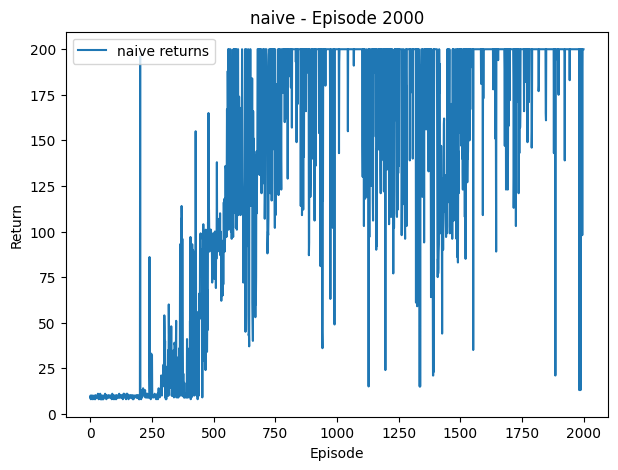

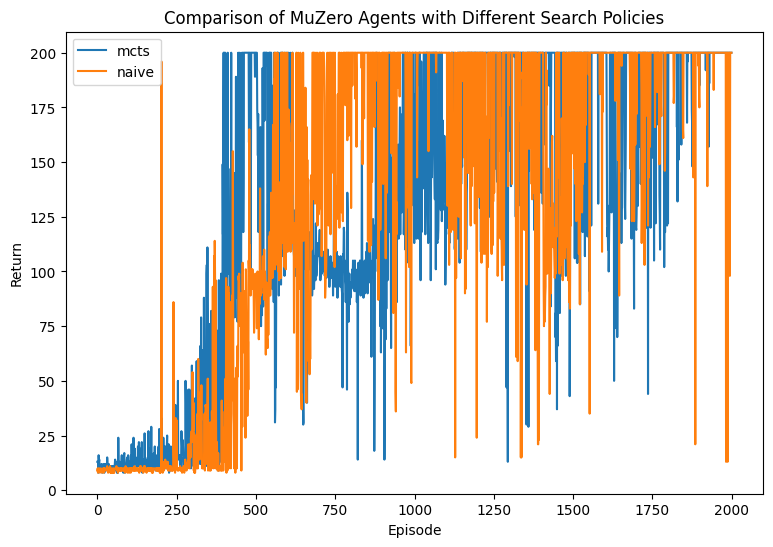

In [16]:

# Dictionary to store returns for each search policy.
all_results = {}
# List of search types to compare. Adjust the list as needed.
search_types = ['mcts', 'naive']

for s_type in search_types:
    print(f"Training with search policy: {s_type}")
    returns = train_with_search_policy(s_type)
    all_results[s_type] = returns

# Plotting the results
plt.figure(figsize=(9, 6))
for s_type in search_types:
    plt.plot(all_results[s_type], label=s_type)
plt.title("Comparison of MuZero Agents with Different Search Policies")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

